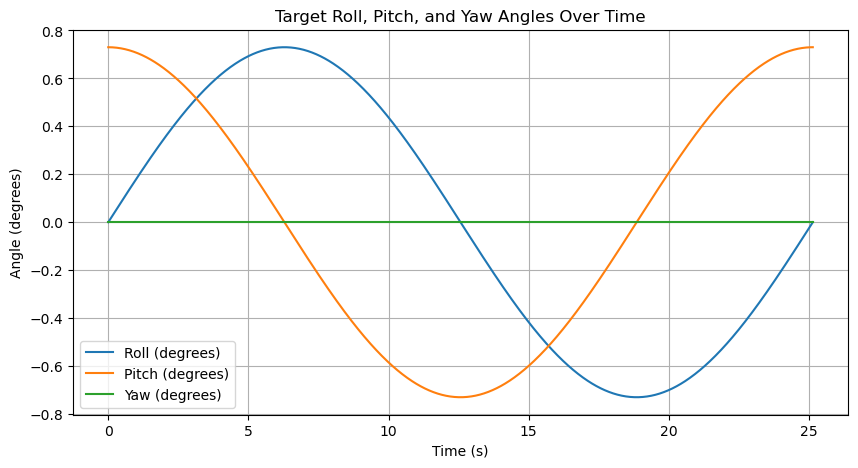

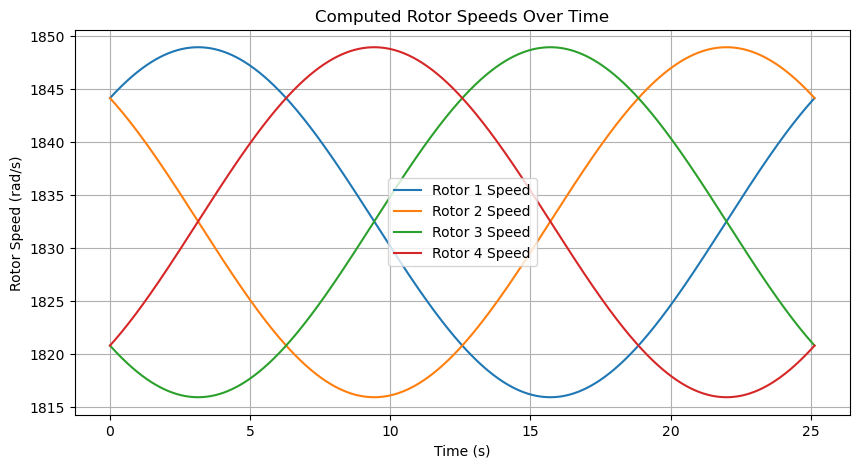

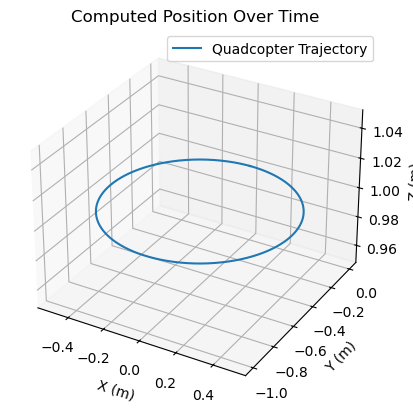

In [7]:

import numpy as np
import matplotlib.pyplot as plt

# Constants
mass = 0.6873  # kg
g = 9.81  # m/s^2
radius = 2  # m
speed = 0.5  # m/s
period = 2 * radius * np.pi / speed # period
omega_circular = speed / radius  # rad/s
a_c = speed**2 / radius  # centripetal acceleration
tilt = np.arctan(a_c / g)  # max tilt angle (roll/pitch amplitude)
time = np.linspace(0, period, 1000)  # simulate for 60 seconds
k = 5.02 * 1e-7  # lift factor
l = 0.1225  # arm length (m)
b = 5.02 * 1e-8  # drag factor
Ixx, Iyy, Izz = 0.005, 0.005, 0.01  # Moments of inertia

# Target roll, pitch, yaw angles
roll = tilt * np.sin(omega_circular * time)  # Roll varies sinusoidally
pitch = tilt * np.cos(omega_circular * time)  # Pitch varies sinusoidally
yaw = np.zeros_like(time)  # Yaw is constant at 0

# Rotation Matrix (combined roll, pitch, yaw)
R = np.zeros((len(time), 3, 3))
for i in range(len(time)):
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(roll[i]), -np.sin(roll[i])],
        [0, np.sin(roll[i]), np.cos(roll[i])]
    ])
    R_y = np.array([
        [np.cos(pitch[i]), 0, np.sin(pitch[i])],
        [0, 1, 0],
        [-np.sin(pitch[i]), 0, np.cos(pitch[i])]
    ])
    R_z = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]  # Yaw is 0
    ])
    R[i] = R_z @ R_y @ R_x

# Compute position in XYZ using rotation matrix
xyz_positions = np.zeros((len(time), 3))
for i in range(len(time)):
    body_frame_force = np.array([0, 0, mass * g])
    world_frame_force = R[i] @ body_frame_force
    xyz_positions[i] = [
        xyz_positions[i - 1, 0] + world_frame_force[0] * (time[1] - time[0]) / mass,
        xyz_positions[i - 1, 1] + world_frame_force[1] * (time[1] - time[0]) / mass,
        1  # Z is fixed at 1 m
    ] if i > 0 else [0, 0, 1]

# Extract X, Y, Z positions
x_new, y_new, z_new = xyz_positions[:, 0], xyz_positions[:, 1], xyz_positions[:, 2]

# Rotor speeds recalculation based on parametric roll and pitch
Fx = mass * (-radius * omega_circular**2 * np.cos(omega_circular * time))
Fy = mass * (-radius * omega_circular**2 * np.sin(omega_circular * time))
Fz = mass * g

tau_phi = Fy * l / 2  # simplified torque for roll
tau_theta = Fx * l / 2    # simplified torque for pitch
tau_psi = np.zeros_like(time)  # yaw torque is zero

T = np.sqrt(Fx**2 + Fy**2 + Fz**2)

omega1_squared = (T / (4 * k) - tau_theta / (2 * k * l) - tau_phi / (2 * k * l) + tau_psi / (4 * b))
omega2_squared = (T / (4 * k) - tau_theta / (2 * k * l) + tau_phi / (2 * k * l) - tau_psi / (4 * b))
omega3_squared = (T / (4 * k) + tau_theta / (2 * k * l) + tau_phi / (2 * k * l) + tau_psi / (4 * b))
omega4_squared = (T / (4 * k) + tau_theta / (2 * k * l) - tau_phi / (2 * k * l) - tau_psi / (4 * b))

omega1 = np.sqrt(np.maximum(omega1_squared, 0))
omega2 = np.sqrt(np.maximum(omega2_squared, 0))
omega3 = np.sqrt(np.maximum(omega3_squared, 0))
omega4 = np.sqrt(np.maximum(omega4_squared, 0))

# Plot Target Roll, Pitch, and Yaw Angles
plt.figure(figsize=(10, 5))
plt.plot(time, np.degrees(roll), label='Roll (degrees)')
plt.plot(time, np.degrees(pitch), label='Pitch (degrees)')
plt.plot(time, np.degrees(yaw), label='Yaw (degrees)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Target Roll, Pitch, and Yaw Angles Over Time')
plt.legend()
plt.grid()
plt.show()

# Plot Rotor Speeds
plt.figure(figsize=(10, 5))
plt.plot(time, omega1, label='Rotor 1 Speed')
plt.plot(time, omega2, label='Rotor 2 Speed')
plt.plot(time, omega3, label='Rotor 3 Speed')
plt.plot(time, omega4, label='Rotor 4 Speed')
plt.xlabel('Time (s)')
plt.ylabel('Rotor Speed (rad/s)')
plt.title('Computed Rotor Speeds Over Time')
plt.legend()
plt.grid()
plt.show()

# 3D Plot of the Trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_new, y_new, z_new, label='Quadcopter Trajectory')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Computed Position Over Time')
ax.legend()
plt.show()
